In [7]:
#Pytorch
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

#Torchvision
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader

#Image Processing
import matplotlib.pyplot as plt
from skimage import io, transform, color
import PIL
from PIL import Image
import augmentations
from augmentations import *

#Others
import sklearn.metrics
from sklearn.metrics import *
import numpy as np
import pandas as pd
import cv2
import time
import os
import copy
from model_summary import *
import pretrainedmodels
import tqdm
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings("ignore")

import dataloaders
from dataloaders import *

## Dataloader
## Dataloader

class dataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):

        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.mask_dir = self.root_dir.replace('images','masks')
        
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,self.data_frame.iloc[idx]['name'])
        image = Image.open(img_name)
        
        mask_name = os.path.join(self.mask_dir,self.data_frame.iloc[idx]['name'])
        mask = io.imread(mask_name)
        mask = np.array([mask,mask,mask]).transpose((1,2,0))
        mask = Image.fromarray(mask)

        label = self.data_frame.iloc[idx]['category']       

        if self.transform:
            image,mask = self.transform(image,mask)
        
        mask_final = mask[0,:,:]
        mask_final[mask_final<0.5] = 0
        mask_final[mask_final>0.5] = 1
        
        return {'image':image, 'category':label, 'mask':mask_final, 'name':self.data_frame.iloc[idx]['name']}
    

def get_dataloader(data_dir, train_csv_path, image_size, img_mean, img_std, batch_size=1):

    data_transforms = {
        'train': Compose([
            Resize(image_size),
            RandomHorizontallyFlip(0.5),
            RandomVerticallyFlip(0.5),
            RandomTranslate((0.2,0.2)),
            RandomRotate(15),
            ToTensor(),
            Normalize(img_mean,img_std)
        ]),
        'valid': Compose([
            Resize(image_size),
            ToTensor(),
            Normalize(img_mean,img_std)
        ]),
        'test': Compose([
            Resize(image_size),
            ToTensor(),
            Normalize(img_mean,img_std)        
        ])
    }

    image_datasets = {}
    dataloaders = {}
    dataset_sizes = {}

    for x in ['train', 'valid', 'test']:
        if x == 'train':
            bs = batch_size
            sh = True
        elif x == 'valid':
            bs = batch_size
            sh = False
        else:
            bs = 1
            sh = False
        image_datasets[x] = dataset(train_csv_path.replace('train',x),root_dir=data_dir,transform=data_transforms[x])
        dataloaders[x] = torch.utils.data.DataLoader(image_datasets[x], batch_size=bs,shuffle=sh, num_workers=8)    
        dataset_sizes[x] = len(image_datasets[x])

    device = torch.device("cuda:0")

    return dataloaders,dataset_sizes,image_datasets,device

## Selector network (U-Net)

def build_selector():
    class unetConv2(nn.Module):
        def __init__(self, in_size, out_size, is_batchnorm):
            super(unetConv2, self).__init__()

            if is_batchnorm:
                self.conv1 = nn.Sequential(nn.Conv2d(in_size, out_size, 3, 1, 1),
                                           nn.BatchNorm2d(out_size),
                                           nn.ReLU(),)
                self.conv2 = nn.Sequential(nn.Conv2d(out_size, out_size, 3, 1, 1),
                                           nn.BatchNorm2d(out_size),
                                           nn.ReLU(),)
            else:
                self.conv1 = nn.Sequential(nn.Conv2d(in_size, out_size, 3, 1, 1),
                                           nn.ReLU(),)
                self.conv2 = nn.Sequential(nn.Conv2d(out_size, out_size, 3, 1, 1),
                                           nn.ReLU(),)
        def forward(self, inputs):
            outputs = self.conv1(inputs)
            outputs = self.conv2(outputs)
            return outputs

    class unetUp(nn.Module):
        def __init__(self, in_size, out_size, is_deconv):
            super(unetUp, self).__init__()
            self.conv = unetConv2(in_size, out_size, False)
            if is_deconv:
                self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
            else:
                self.up = nn.UpsamplingBilinear2d(scale_factor=2)

        def forward(self, inputs1, inputs2):
            outputs2 = self.up(inputs2)
            offset = outputs2.size()[2] - inputs1.size()[2]
            padding = 2 * [offset // 2, offset // 2]
            outputs1 = F.pad(inputs1, padding)
            return self.conv(torch.cat([outputs1, outputs2], 1))

    class unet(nn.Module):

        def __init__(self, feature_scale=8, n_classes=1, is_deconv=True, in_channels=3, is_batchnorm=True):
            super(unet, self).__init__()
            self.is_deconv = is_deconv
            self.in_channels = in_channels
            self.is_batchnorm = is_batchnorm
            self.feature_scale = feature_scale

            filters = [32, 64, 128, 256, 512, 1024, 2048]
            filters = [int(x / self.feature_scale) for x in filters]

            #downsampling
            self.conv1 = unetConv2(self.in_channels, filters[0], self.is_batchnorm)
            self.maxpool1 = nn.MaxPool2d(kernel_size=2)

            self.conv2 = unetConv2(filters[0], filters[1], self.is_batchnorm)
            self.maxpool2 = nn.MaxPool2d(kernel_size=2)

            self.conv3 = unetConv2(filters[1], filters[2], self.is_batchnorm)
            self.maxpool3 = nn.MaxPool2d(kernel_size=2)

            self.conv4 = unetConv2(filters[2], filters[3], self.is_batchnorm)
            self.maxpool4 = nn.MaxPool2d(kernel_size=2)
                    
            self.conv5 = unetConv2(filters[3], filters[4], self.is_batchnorm)
            self.maxpool5 = nn.MaxPool2d(kernel_size=2)
            
            self.conv6 = unetConv2(filters[4], filters[5], self.is_batchnorm)
            self.maxpool6 = nn.MaxPool2d(kernel_size=2)
            
            self.center = unetConv2(filters[5], filters[6], self.is_batchnorm)

            # upsampling
            
            self.up_concat6 = unetUp(filters[6], filters[5], self.is_deconv)
            self.up_concat5 = unetUp(filters[5], filters[4], self.is_deconv)
            self.up_concat4 = unetUp(filters[4], filters[3], self.is_deconv)
            
#             self.up_concat3 = unetUp(filters[3], filters[2], self.is_deconv)
#             self.up_concat2 = unetUp(filters[2], filters[1], self.is_deconv)
#             self.up_concat1 = unetUp(filters[1], filters[0], self.is_deconv)

            # final conv (without any concat)
            self.final = nn.Conv2d(filters[3], n_classes, 1)

        def forward(self, inputs):
            conv1 = self.conv1(inputs)
            maxpool1 = self.maxpool1(conv1)

            conv2 = self.conv2(maxpool1)
            maxpool2 = self.maxpool2(conv2)

            conv3 = self.conv3(maxpool2)
            maxpool3 = self.maxpool3(conv3)

            conv4 = self.conv4(maxpool3)
            maxpool4 = self.maxpool4(conv4)
            
            conv5 = self.conv5(maxpool4)
            maxpool5 = self.maxpool5(conv5)
            
            conv6 = self.conv6(maxpool5)
            maxpool6 = self.maxpool6(conv6)

            center = self.center(maxpool6)
            up6 = self.up_concat6(conv6, center)
            #print(conv5.shape,up6.shape)
            up5 = self.up_concat5(conv5, up6)
            up4 = self.up_concat4(conv4, up5)
            #up3 = self.up_concat3(conv3, up4)
            #up2 = self.up_concat2(conv2, up3)
            #up1 = self.up_concat1(conv1, up2)

            final = self.final(up4)

            return final
    
    model = unet()
    return model

# a = build_selector()

# summary(a.cuda(),(3,256,256))

#summary(a.cuda(),(3,224,224))

## Predictor-Discriminator-Baseline
def build_pdb():

    class mdl(nn.Module):
        def __init__(self,base_model):
            super().__init__()
            self.base = base_model 
            self.gap = nn.AdaptiveAvgPool2d((1,1))
            self.fc1 = nn.Linear(512,2)

        def forward(self, x):
            x_base = self.base(x)
            x = self.gap(x_base)
            x = x.view(x.size(0), -1)
            x = self.fc1(x)
            return x,x_base 

    v = models.vgg16_bn(pretrained=True)
    v1 = nn.Sequential(*list(v.children())[:-1])

    #r = models.resnet101(pretrained=True)
    #r1 = nn.Sequential(*list(r.children())[:-2])
    
    model = mdl(v1[-1][:-1])
    model.load_state_dict(torch.load('./Weights/grad_cam_vgg_16_oxford.pt'))
        
    return model

# IoU
def get_IoU(pred, targs):
    return (pred*targs).sum() / ((pred+targs).sum() - (pred*targs).sum())
    
## Sampler

def sampler(gen_prob):

    # Sampling
    samples = np.random.binomial(1, gen_prob, gen_prob.shape)

    return samples

def test_samples(gen_prob):
    out = torch.zeros(gen_prob.shape)
    out[gen_prob>0.5] = 1
    return out

## Mask generation

class get_prob_mask(torch.nn.Module):
    def __init__(self,img_size,patch_size):
        super(get_prob_mask, self).__init__()
        self.i_h = img_size[0]
        self.i_w = img_size[1]
        self.p_h = patch_size[0]
        self.p_w = patch_size[1]
        
    def forward(self,x):
        b,c,h,w = x.size()
        mask = torch.zeros((b,c,self.i_h,self.i_w))
        for i in range(h):
            for j in range(w):
                mask[0][0][i*self.p_h:(i+1)*self.p_h,j*self.p_w:(j+1)*self.p_w] = x[0][0][i,j]
                #import pdb;pdb.set_trace()
        return mask
    

## DC-INVASE class

class dc_invase():
    def __init__(self):
        
        #Initialization
        self.data_dir =  '../Data/oxford_pets/sparse_images/'
        self.train_csv = '../CSV/oxford_pet_train.csv'
        self.num_epochs = 10
        self.input_shape = (256,256)
        self.patch_shape = (8,8)
        self.batch_size = 1
        self.img_mean = [0,0,0]#[0.485, 0.456, 0.406]
        self.img_std = [1,1,1]#[0.229, 0.224, 0.225]
        self.alpha = 1
        self.beta = 0.003#0.05 for 64x64
        self.exp_name = './Weights/dci_patchwise_8x8_oxford_share'
        
        #Define the four models
        self.selector = build_selector()
        self.baseline = build_pdb()
        
        #Put them on the GPU
        self.selector = self.selector.cuda()
        self.baseline = self.baseline.cuda()
        
        #Get the dataloaders
        self.dataloaders,self.dataset_sizes,self.dataset,self.device = get_dataloader(self.data_dir,self.train_csv,\
                                                        self.input_shape,self.img_mean,self.img_std,self.batch_size)
        
        #Define optimizers one for each model
        self.optimizer_sel = optim.Adam(self.selector.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5, amsgrad=False)
        self.optimizer_base = optim.Adam(self.baseline.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5, amsgrad=False)
        
        #Define the interpolation function
        self.prob_mask = get_prob_mask(self.input_shape,self.patch_shape)
             
    def train(self):
        
        since = time.time()
        best_iou = 0

        for epoch in range(self.num_epochs):
            print('Epoch {}/{}'.format(epoch, self.num_epochs - 1),flush=True)
            print('-' * 10,flush=True)

            # Each epoch has a training and validation phase
            for phase in ['train', 'valid']:
                if phase == 'train':                
                    #Set the models to training mode
                    self.selector.train()
                    self.baseline.train()
                
                else:
                    #Set the models to evaluation mode
                    self.selector.eval()
                    self.baseline.eval()
                    
                #Keep a track of all the three loss
                running_sel_loss = 0.0
                running_base_loss = 0.0
                running_pred_loss = 0.0
                running_dis_loss = 0.0
                running_final_base = 0.0
                running_spa = 0.0
              
                #Metrics : accuracy
                running_pred_acc = 0
                running_dis_acc = 0
                running_base_acc = 0
                running_iou = 0

                #tqdm bar
                pbar = tqdm(total=self.dataset_sizes[phase])

                # Iterate over data.
                for sampled_batch in self.dataloaders[phase]:

                    inputs = sampled_batch['image']
                    labels = sampled_batch['category']
                    mask = sampled_batch['mask']
                    
                    #Input needs to be float and labels long
                    inputs = inputs.float().to(self.device)
                    labels = labels.long().to(self.device)
                    mask = mask.to(self.device)
                    
                    # zero the parameter gradients
                    self.optimizer_sel.zero_grad()
                    self.optimizer_base.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        
                        #import pdb;pdb.set_trace()
                        
                        #Generate predictor output probabilities
                        base_out,_ = self.baseline(inputs)
                        base_prob = F.softmax(base_out)
                        _, base_preds = torch.max(base_out, 1)
                        
                        #=>Baseline Cross entropy
                        base_ce_loss = F.cross_entropy(base_out,labels)
                        
                        #Generate selection probabilites using selector function.
                        sel_prob = self.selector(inputs)
                        #sel_prob = F.sigmoid(sel_prob)
                        sel_prob = sel_prob - sel_prob.min()
                        sel_prob = sel_prob/sel_prob.max()
                        
                        pred_ce_loss = 0
                        dis_loss = 0
                        sel_loss = 0
                        sparsity = 0
                        iou = 0
                        
                        no_of_samples = 1
                        for sampling_ind in range(no_of_samples):
                        
                            #Sample using the selector distribution.
                            bin_samples = sampler(sel_prob.data.cpu().numpy())
                            
                            #print(bin_samples,phase)
                            
                            bin_samples = torch.Tensor(bin_samples).to(self.device)
                            
                            #Interpolate the selector output
                            bin_mask = self.prob_mask(bin_samples).to(self.device)
                            #print(bin_samples)
                            
                            #Compute the sparsity and iou
                            sparsity+=torch.mean(bin_samples)
                            #print(sparsity)
                            iou+=get_IoU(bin_mask,mask)

                            #Compute the Complementary selection probability
                            comp_bin_mask = 1 - bin_mask

                            #Generate X_S the selection probability masked image
                            x_s = inputs*bin_mask

                            #Generate X_S_bar the complementary selection probability masked image
                            x_s_bar = inputs*comp_bin_mask

                            #Generate predictor output probabilities using the baseline cnn
                            pred_out,_ = self.baseline(x_s)
                            pred_prob = F.softmax(pred_out)
                            _, pred_preds = torch.max(pred_out, 1)

                            #Generate discriminator probabilities using the baseline cnn
                            dis_out,_ = self.baseline(x_s_bar)
                            dis_prob = F.softmax(dis_out)
                            _, dis_preds = torch.max(dis_out, 1)
                            #dis_metric += torch.mean(torch.abs(dis_prob-0.5)) 
                            #print(torch.mean(torch.abs(dis_prob-0.5)))
                            
                            #Predictor Cross entropy
                            pred_ce_loss += F.cross_entropy(pred_out,labels)

                            #Discriminator loss = probability of the actual label
                            dis_loss += dis_prob[0][labels[0]]
                            #print(pred_out,dis_out,labels)

                            with torch.no_grad():
                                dis_ce_loss = F.cross_entropy(dis_out,labels)

                                #first KL divergence term
                                kl_1 = -base_ce_loss + pred_ce_loss

                                #second KL divergence term
                                kl_2 = -base_ce_loss + dis_ce_loss

                                #the difference in the two KL divergence terms
                                kl_diff = kl_1 - self.alpha*kl_2

                            #Selector function loss
                            l1_loss = torch.mean(sel_prob)                        

                            distribution_loss = torch.mean(bin_samples*torch.log(sel_prob + 1e-8) + (1-bin_samples)*torch.log(1 - sel_prob + 1e-8))

                            sel_loss += distribution_loss*kl_diff + self.beta*l1_loss
                            #print(distribution_loss*kl_diff,self.beta*l1_loss)
                            
                        pred_ce_loss /= no_of_samples
                        dis_loss /= no_of_samples
                        sel_loss /= no_of_samples
                        sparsity /= no_of_samples
                        iou /= no_of_samples
                        
                        final_baseline_loss = base_ce_loss + pred_ce_loss + dis_loss
                        
                        # backward + optimize only if in training phase
                        if phase == 'train':
                            
                            #The gradients of pred_ce_loss should not update the params of disc or sel
                            final_baseline_loss.backward(retain_graph=True)
                            self.optimizer_sel.zero_grad()
                            self.optimizer_base.step()
                            
                            #Update sel
                            sel_loss.backward()
                            self.optimizer_base.zero_grad()
                            self.optimizer_sel.step()
                                    
                    # statistics
                    running_sel_loss += sel_loss.item() * inputs.size(0)
                    running_pred_loss += pred_ce_loss.item() * inputs.size(0)
                    running_dis_loss += dis_loss.item() * inputs.size(0)
                    running_base_loss += base_ce_loss.item() * inputs.size(0)
                    running_final_base += final_baseline_loss.item() * inputs.size(0)
                    running_spa += sparsity *inputs.size(0)
                
                    running_pred_acc += torch.sum(pred_preds == labels.data)
                    running_dis_acc += torch.sum(dis_preds == (1-labels.data))
                    running_base_acc += torch.sum(base_preds == labels.data)
                    running_iou += iou * inputs.size(0)
                    
                    pbar.update(inputs.shape[0])
                pbar.close()

                epoch_base_loss = running_base_loss / self.dataset_sizes[phase]
                epoch_final_base = running_final_base / self.dataset_sizes[phase]
                epoch_sel_loss = running_sel_loss / self.dataset_sizes[phase]
                epoch_pred_loss = running_pred_loss / self.dataset_sizes[phase]
                epoch_dis_loss = running_dis_loss / self.dataset_sizes[phase]
                epoch_spa = running_spa / self.dataset_sizes[phase]
                
                epoch_base_acc = running_base_acc.double()/ self.dataset_sizes[phase]
                epoch_pred_acc = running_pred_acc.double() / self.dataset_sizes[phase]
                epoch_dis_acc = running_dis_acc.double() / self.dataset_sizes[phase]
                epoch_iou = running_iou / self.dataset_sizes[phase]
                
                print('{} Final_Base: {:.4f} Base_Loss: {:.4f} Sel_Loss: {:.4f} Pred_Loss: {:.4f} Dis_Loss: {:.4f} Spa: {:.4f} BAC: {:.4f} PAC: {:.4f} DAC: {:.4f} IoU: {:.4f}'.format(
                    phase, epoch_final_base, epoch_base_loss, epoch_sel_loss, epoch_pred_loss, epoch_dis_loss, epoch_spa, epoch_base_acc, epoch_pred_acc, epoch_dis_acc,epoch_iou))

                # deep copy the model
                if phase == 'valid' and epoch_iou > best_iou:
                    
                    best_iou = epoch_iou
                    torch.save(self.selector.state_dict(),self.exp_name+'_sel.pt')
                    torch.save(self.baseline.state_dict(),self.exp_name+'_base.pt')
                    #import pdb;pdb.set_trace()


        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best iou: {:4f}'.format(best_iou))

        torch.save(self.baseline.state_dict(),self.exp_name+'_base_final.pt')
        torch.save(self.selector.state_dict(),self.exp_name+'_sel_final.pt')

        print('Training completed finally !!!!!')
        
    def get_cam(self):
                
        self.selector.load_state_dict(torch.load(self.exp_name+'_sel_final.pt'))
        self.selector.eval()
        
        acc = 0
        total = 0
        mode = 'test'

        cm = []
        m = []
        bm = []
        
        params = list(self.selector.parameters())                        
        weight_softmax = torch.squeeze(params[-2].data)
        
        iou = 0
        
        with torch.no_grad():
            
            pbar = tqdm(total=self.dataset_sizes[mode])
            for data in self.dataloaders[mode]:

                inputs = data['image']
                labels = data['category']

                inputs = inputs.to(self.device)
                labels = labels.to(self.device) 
                
                sel_prob = self.selector(inputs)
                sel_prob = sel_prob - sel_prob.min()
                sel_prob = sel_prob/sel_prob.max()

                #Threshold using 0.5
                #bin_samples = test_samples(sel_prob.data)
                
                #Sample using the distribution induced
                bin_samples = sampler(sel_prob.data.cpu().numpy())
                bin_samples = torch.Tensor(bin_samples).to(self.device)
                bin_mask = self.prob_mask(bin_samples).to(self.device) 

                base_path = '../Experiments/Oxford_pets/'
                name = data['name'][0]

                #heatmap = cv2.applyColorMap(np.uint8(255*bin_mask.cpu().numpy().squeeze()), cv2.COLORMAP_JET)
                heatmap = bin_mask.cpu().numpy().squeeze()
                heatmap = np.expand_dims(heatmap,axis=2)
                #heatmap = np.float32(heatmap) / 255
                cam_f = heatmap*np.float32(inputs.cpu().numpy().squeeze().transpose((1,2,0)))
                cam_f = cam_f / np.max(cam_f)
                #cam_f = heatmap
                pr = name.replace('.j','_bin_8x8_samp_share_1_final.j')
                cv2.imwrite(base_path+pr,cam_f*255)

                
                pbar.update(inputs.shape[0])
                
            pbar.close()
        

    def return_model(self):
        self.selector.load_state_dict(torch.load(self.exp_name+'_sel.pt'))
        self.selector.eval()
        return self.selector,self.dataloaders['valid']

In [8]:
dc = dc_invase()

In [9]:
dc.get_cam()

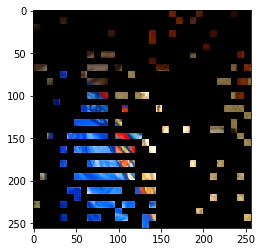

In [11]:
plt.imshow(cv2.imread('../Experiments/Oxford_pets/cat_Abyssinian_105_bin_8x8_samp_share_1_final.jpg'))

In [3]:
dc.train()

Epoch 0/9
----------



train Final_Base: 1.5819 Base_Loss: 0.3980 Sel_Loss: 0.0196 Pred_Loss: 0.6807 Dis_Loss: 0.5032 Spa: 0.1663 BAC: 0.8414 PAC: 0.5733 DAC: 0.4797 IoU: 0.1040



valid Final_Base: 2.5795 Base_Loss: 0.8913 Sel_Loss: 1.8712 Pred_Loss: 1.2442 Dis_Loss: 0.4440 Spa: 0.2011 BAC: 0.5930 PAC: 0.4510 DAC: 0.5570 IoU: 0.1405
Epoch 1/9
----------



train Final_Base: 1.4356 Base_Loss: 0.3142 Sel_Loss: 0.1223 Pred_Loss: 0.6671 Dis_Loss: 0.4543 Spa: 0.1739 BAC: 0.8704 PAC: 0.6003 DAC: 0.5713 IoU: 0.1119



valid Final_Base: 2.0511 Base_Loss: 0.7757 Sel_Loss: 3.7822 Pred_Loss: 0.7615 Dis_Loss: 0.5140 Spa: 0.1502 BAC: 0.6560 PAC: 0.4980 DAC: 0.4870 IoU: 0.1204
Epoch 2/9
----------



train Final_Base: 1.3352 Base_Loss: 0.2728 Sel_Loss: 0.1270 Pred_Loss: 0.6850 Dis_Loss: 0.3775 Spa: 0.0519 BAC: 0.8884 PAC: 0.5568 DAC: 0.6593 IoU: 0.0383



valid Final_Base: 2.8271 Base_Loss: 1.4054 Sel_Loss: 7.2609 Pred_Loss: 0.9217 Dis_Loss: 0.5000 Spa: 0.0926 BAC: 0.5020 PAC: 0.4970 DAC: 0.4970 IoU: 0.0874
Epoch 3/9
----------



train Final_Base: 1.2419 Base_Loss: 0.2363 Sel_Loss: 0.2041 Pred_Loss: 0.6628 Dis_Loss: 0.3428 Spa: 0.0628 BAC: 0.9070 PAC: 0.6048 DAC: 0.6743 IoU: 0.0500



valid Final_Base: 2.3487 Base_Loss: 1.1057 Sel_Loss: 0.6062 Pred_Loss: 0.7250 Dis_Loss: 0.5179 Spa: 0.1464 BAC: 0.4140 PAC: 0.5000 DAC: 0.4940 IoU: 0.1147
Epoch 4/9
----------



train Final_Base: 1.1801 Base_Loss: 0.2198 Sel_Loss: 0.2909 Pred_Loss: 0.6380 Dis_Loss: 0.3223 Spa: 0.0840 BAC: 0.9225 PAC: 0.6363 DAC: 0.7004 IoU: 0.0626



valid Final_Base: 1.8585 Base_Loss: 0.6626 Sel_Loss: 9.9094 Pred_Loss: 0.6929 Dis_Loss: 0.5030 Spa: 0.1741 BAC: 0.5260 PAC: 0.4990 DAC: 0.4960 IoU: 0.1321
Epoch 5/9
----------



train Final_Base: 1.1404 Base_Loss: 0.2020 Sel_Loss: 0.2132 Pred_Loss: 0.6524 Dis_Loss: 0.2859 Spa: 0.0521 BAC: 0.9200 PAC: 0.6273 DAC: 0.7354 IoU: 0.0366



valid Final_Base: 1.8657 Base_Loss: 0.6798 Sel_Loss: 3.5113 Pred_Loss: 0.6863 Dis_Loss: 0.4996 Spa: 0.1118 BAC: 0.5060 PAC: 0.5050 DAC: 0.4970 IoU: 0.0849
Epoch 6/9
----------



train Final_Base: 1.1081 Base_Loss: 0.1665 Sel_Loss: 0.2572 Pred_Loss: 0.6514 Dis_Loss: 0.2902 Spa: 0.0634 BAC: 0.9370 PAC: 0.6318 DAC: 0.7289 IoU: 0.0493



valid Final_Base: 2.0316 Base_Loss: 0.7536 Sel_Loss: 0.8791 Pred_Loss: 0.6992 Dis_Loss: 0.5788 Spa: 0.1853 BAC: 0.5300 PAC: 0.5000 DAC: 0.4200 IoU: 0.1279
Epoch 7/9
----------



train Final_Base: 1.0635 Base_Loss: 0.1641 Sel_Loss: 0.4092 Pred_Loss: 0.6067 Dis_Loss: 0.2927 Spa: 0.1448 BAC: 0.9385 PAC: 0.6788 DAC: 0.7194 IoU: 0.1032



valid Final_Base: 2.0924 Base_Loss: 0.8637 Sel_Loss: 1.7596 Pred_Loss: 0.6954 Dis_Loss: 0.5334 Spa: 0.1276 BAC: 0.5450 PAC: 0.5000 DAC: 0.4690 IoU: 0.1233
Epoch 8/9
----------



train Final_Base: 1.0041 Base_Loss: 0.1459 Sel_Loss: 0.3882 Pred_Loss: 0.5847 Dis_Loss: 0.2736 Spa: 0.1101 BAC: 0.9470 PAC: 0.6948 DAC: 0.7364 IoU: 0.1127



valid Final_Base: 1.9933 Base_Loss: 0.7558 Sel_Loss: 3.2931 Pred_Loss: 0.7343 Dis_Loss: 0.5032 Spa: 0.1381 BAC: 0.5050 PAC: 0.5000 DAC: 0.4970 IoU: 0.1351
Epoch 9/9
----------



train Final_Base: 0.9764 Base_Loss: 0.1199 Sel_Loss: 0.4347 Pred_Loss: 0.5891 Dis_Loss: 0.2674 Spa: 0.1226 BAC: 0.9565 PAC: 0.6803 DAC: 0.7429 IoU: 0.1007



valid Final_Base: 2.3145 Base_Loss: 0.9432 Sel_Loss: 2.5547 Pred_Loss: 0.8503 Dis_Loss: 0.5210 Spa: 0.1862 BAC: 0.5350 PAC: 0.5000 DAC: 0.4800 IoU: 0.1354
Training complete in 78m 51s
Best iou: 0.140546
Training completed finally !!!!!


In [ ]:
!nvidia-smi